# Example 5. Uncalibrated modulators: Oblique plane structured illumination microscopy

Load raw [oblique plane structured illumination microscopy (OPSIM)](https://www.biorxiv.org/content/10.1101/2022.05.19.492671v1.full), process data for rotation and registration, determine SIM pattern infromation, and run reconstruction.

Instrument designed and built by Bingying Chen, Bo-Jui Chang, and Reto Fiolka.  
Cardiomyocyte cell samples labeled for alpha-actinin 2 by James Hayes and Dylan Burnette.   
All imaging by Reto Fiolka. 

### Download data from Zenodo and extract

Data available from [OPSIM Zenodo repository](https://zenodo.org/record/6481084#.YmVM-7lOmHs).  Please download and extract "1_CH00_000000.tif" into data/example_005/raw_data. Once this is done, you can run this example.

### Import libraries

In [1]:
import numpy as np
from numpy import fft
from pathlib import Path
import mcsim.analysis.sim_reconstruction as sim
from mcsim.analysis import analysis_tools
from localize_psf import rois
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from skimage.transform import rotate
import napari
import tifffile
import gc
from example005_resources.deskew_opm_data import deskew
import itk

### Define data paths to raw OPSIM stack and 2D PSF extracted from many beads

In [2]:
opsim_file_path = Path("data", "example_005", "raw_data", "Mito", "1_CH00_000000.tif")
psf_file_path = Path("example005_resources", "psf2d.tif")

### Define experimental metadata

In [107]:
# extracted from text file provided with acquisition
n_colors = 1
n_angles = 3
n_phases = 3
ns = 251
ny = 200
nx = 1024
pixel_size = 0.114 # um
ds = 0.320 # um - scan step size, not coverslip z
na = 1.0 # Snouty NA
excitation_wavelengths = 0.488 # um
emission_wavelengths = 0.580 # um
tilt_angle = 45.0

# transformed pixel spacing. qi2lab deskew deskews onto an isotropic grid in xy
coverslip_dz = pixel_size * np.sin(tilt_angle)
coverslip_dy = pixel_size
coverslip_dx = pixel_size

### Load and parse data into angles and phases

In [4]:
# create array to hold all raw opsim images
sim_images = np.zeros((n_colors,n_angles,n_phases,ns,ny,nx),dtype=np.uint16)

# loop through TIFF file and load each raw opsim image into proper metadata location
page_idx = 0
with tifffile.TiffFile(opsim_file_path) as tif:
    n_pages = len(tif.pages)
    for channel_idx in range(n_colors):
        for angle_idx in range(n_angles):
            for phase_idx in range(n_phases):
                for scan_idx in range(ns):
                    sim_images[channel_idx,angle_idx,phase_idx,scan_idx,:,:] = tif.pages[page_idx].asarray()
                    page_idx = page_idx + 1

### Visualize OPM SIM data in native reference frame

In [ ]:
# add images to napari viewer with scale information
viewer = napari.view_image(sim_images,name='Raw OPSIM data',scale=(1,1,1,ds,pixel_size,pixel_size))

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

# label sliders in napari viewer
viewer.dims.axis_labels = ['c','a','p','s','y','x']

### Calculate deskewed widefield equivalent images for registration
  
Orthogonal deskew function for OPM extracted from [qi2lab OPM package](https://www.github.com/qi2lab/opm). 

In [5]:
# deskew one channel/angle/phase to get the size of the image
test_deskew = deskew(sim_images[0,0,0,:],tilt_angle,ds,pixel_size)
n_coverslip_z = test_deskew.shape[0]
n_coverslip_y = test_deskew.shape[1]
n_coverslip_x = test_deskew.shape[2]
coverslip_wf_images = np.zeros((n_colors,n_angles,n_coverslip_z,n_coverslip_y,n_coverslip_x),dtype=np.uint16)

# perform deskewing for all widefield equivalent views (average over phases)
for channel_idx in range(n_colors):
    for angle_idx in range(n_angles):
        for phase_idx in range(n_phases):
            image_plane = deskew(np.flipud(np.nanmean(sim_images[channel_idx,angle_idx,:,:,:,:],axis=0)),tilt_angle,ds,pixel_size)
            coverslip_wf_images[channel_idx,angle_idx,:] = image_plane

# clean up variables
del test_deskew
gc.collect()

8172

### Rotate deskewed widefield equivalent images with prior info from instrument

In [6]:
# pad images to be square
max_size = np.maximum(n_coverslip_y,n_coverslip_x)

if max_size > n_coverslip_y:
    pad_amount_y = np.abs(max_size-n_coverslip_y)//2
else:
    pad_amount_y = 0
if max_size > n_coverslip_x:
    pad_amount_x = np.abs(max_size-n_coverslip_x)//2
else:
    pad_amount_x = 0

pad_width = ((0,0),(0,0),(0,0),(pad_amount_y,pad_amount_y+1),(pad_amount_x,pad_amount_x))

coverslip_rotated_wf_images = np.pad(coverslip_wf_images,pad_width=pad_width)

# rotation angle guesses from instrument design
rotation = [60,0,-60]

# perform rotation across all z planes for each channel + angle
for channel_idx in range(n_colors):
    for angle_idx in range(n_angles):
        for z_idx in range(n_coverslip_z):
            rotated_plane = rotate(coverslip_rotated_wf_images[channel_idx,angle_idx,z_idx,:,:],
                                    angle=rotation[angle_idx],
                                    center=None,
                                    resize=False,
                                    mode='constant',
                                    cval=0,
                                    preserve_range=True)
            coverslip_rotated_wf_images[channel_idx,angle_idx,z_idx,:,:] = rotated_plane

# clean up variables
del coverslip_wf_images
gc.collect()

0

### Determine image registration in coverslip reference frame using deskewed and rotated widefield images

In [29]:
# create ITK array for fixed view
# itk-elastix currently supports np.float32 only
channel_idx = 0
angle_idx = 1
fixed_image_a001 = itk.GetImageFromArray(coverslip_rotated_wf_images[channel_idx,angle_idx,:].astype(np.float32))

# first, perform translation only registration
parameter_object = itk.ParameterObject.New()
resolutions = 4
default_translation_parameter_map = parameter_object.GetDefaultParameterMap('translation',resolutions)
parameter_object.AddParameterMap(default_translation_parameter_map)

# second, perform rigid registration
default_rigid_parameter_map = parameter_object.GetDefaultParameterMap('rigid',resolutions)
parameter_object.AddParameterMap(default_rigid_parameter_map)

# third, perform affine registration
default_affine_parameter_map = parameter_object.GetDefaultParameterMap('affine',resolutions)
default_affine_parameter_map['FinalBSplineInterpolationOrder'] = ['0']
parameter_object.AddParameterMap(default_affine_parameter_map)

# Call registration functions to determine registration of rotated view (angle_idx=[0,2]) to center view (angle_idx=1)

# create ITK array for +60 rotated view
# itk-elastix currently supports np.float32 only
angle_idx = 0
moving_image_a000 = itk.GetImageFromArray(coverslip_rotated_wf_images[channel_idx,angle_idx,:].astype(np.float32))

# refine rigid transformation with affine registration
result_image_a000, result_transform_parameters_a000_to_a001 = itk.elastix_registration_method(
    fixed_image_a001, moving_image_a000,
    parameter_object=parameter_object,
    log_to_console=False)

# clean up variables for +60 rotated view
del moving_image_a000 #, result_image_a000
gc.collect()

# create ITK array for -60 rotated view
# itk-elastix currently supports np.float32 only
angle_idx = 2
moving_image_a002 = itk.GetImageFromArray(coverslip_rotated_wf_images[channel_idx,angle_idx,:].astype(np.float32))

# register angle_idx=2 to angle_idx=1
# begin with rigid registration
result_image_a002, result_transform_parameters_a002_to_a001 = itk.elastix_registration_method(
    fixed_image_a001, moving_image_a002,
    parameter_object=parameter_object,
    log_to_console=False)

# clean up variables for -60 rotated view
del moving_image_a002 #, result_image_a002 
del coverslip_rotated_wf_images
gc.collect()

0

In [32]:
# add images to napari viewer with scale information
viewer = napari.view_image(result_image_a000,name='Registered deskewed angle 0',scale=(coverslip_dz,coverslip_dy,coverslip_dx))
viewer.add_image(fixed_image_a001,name='Registered deskewed angle 1',scale=(coverslip_dz,coverslip_dy,coverslip_dx))
viewer.add_image(result_image_a002,name='Registered deskewed angle 2',scale=(coverslip_dz,coverslip_dy,coverslip_dx))

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

# label sliders in napari viewer
viewer.dims.axis_labels = ['z','y','x']

### Deskew all raw OPSIM images

In [34]:
# deskew one channel/angle/phase to get the size of the image
test_deskew = deskew(sim_images[0,0,0,:],tilt_angle,ds,pixel_size)
n_coverslip_z = test_deskew.shape[0]
n_coverslip_y = test_deskew.shape[1]
n_coverslip_x = test_deskew.shape[2]

# create array to hold all deskewed images
coverslip_opsim_images = np.zeros((n_colors,n_angles,n_phases,n_coverslip_z,n_coverslip_y,n_coverslip_x),dtype=np.uint16)

# perform deskewing for all raw opsim views
for channel_idx in range(n_colors):
    for angle_idx in range(n_angles):
        for phase_idx in range(n_phases):
            coverslip_opsim_images[channel_idx,angle_idx,phase_idx,:] = deskew(np.flipud(sim_images[channel_idx,angle_idx,phase_idx,:,:,:]),tilt_angle,ds,pixel_size)

# clean up variables
del test_deskew, sim_images
gc.collect()

37667

### Rotate deskewed raw OPSIM images

In [35]:
# pad images to be square to hold rotated images
max_size = np.maximum(n_coverslip_y,n_coverslip_x)

if max_size > n_coverslip_y:
    pad_amount_y = np.abs(max_size-n_coverslip_y)//2
else:
    pad_amount_y = 0
if max_size > n_coverslip_x:
    pad_amount_x = np.abs(max_size-n_coverslip_x)//2
else:
    pad_amount_x = 0

pad_width = ((0,0),(0,0),(0,0),(0,0),(pad_amount_y,pad_amount_y+1),(pad_amount_x,pad_amount_x))
rotated_coverslip_opsim_images = np.pad(coverslip_opsim_images,pad_width=pad_width)

# rotation angle guesses from instrument design
rotation = [60,0,-60]

# perform rotation across all z planes for each channel + angle
for channel_idx in range(n_colors):
    for angle_idx in range(n_angles):
        for phase_idx in range(n_phases):
            for z_idx in range(n_coverslip_z):
                rotated_plane = rotate(rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,z_idx,:,:],
                                        angle=rotation[angle_idx],
                                        center=None,
                                        resize=False,
                                        mode='constant',
                                        cval=0,
                                        preserve_range=True)
                rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,z_idx,:,:] = rotated_plane

# clean up variables
del coverslip_opsim_images
gc.collect()

0

### Register deskewed raw OPSIM images using transformation matrices found using deskewed WF images

In [36]:
# loop over all channel/angle/phase and apply transformations for angle_idx=[0,2] to angle_idx=1
for channel_idx in range(n_colors):
    for angle_idx in range(n_angles):
        for phase_idx in range(n_phases):
            if angle_idx == 0:
                result_image_transformix = itk.transformix_filter(rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,:,:,:].astype(np.float32),result_transform_parameters_a000_to_a001)
                rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,:,:,:]=result_image_transformix.astype(np.uint16)
            elif angle_idx == 2:
                result_image_transformix = itk.transformix_filter(rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,:,:,:].astype(np.float32),result_transform_parameters_a002_to_a001)
                rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,:,:,:]=result_image_transformix.astype(np.uint16)

### Visualize registered deskewed images in coverslip reference frame

In [67]:
# add images to napari viewer with scale information
viewer = napari.view_image(rotated_coverslip_opsim_images[0,0,:],name='Registered deskewed angle 0',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx))
viewer.add_image(rotated_coverslip_opsim_images[0,1,:],name='Registered deskewed angle 1',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx))
viewer.add_image(rotated_coverslip_opsim_images[0,2,:],name='Registered deskewed angle 2',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx))

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

# label sliders in napari viewer
viewer.dims.axis_labels = ['c','a','p','z','y','x']

### Set ROI to middle of data and extract crop

In [69]:
# set yx width of ROI
roi_sy=399
roi_sx=399
roi = rois.get_centered_roi([rotated_coverslip_opsim_images.shape[4]//2, rotated_coverslip_opsim_images.shape[5]//2], [roi_sy, roi_sx])

# set these using the z slices that contain data from the Napari preview window above
z_roi_low = 25
z_roi_high = 100

# extract crop
opsim_images_to_process = rotated_coverslip_opsim_images[:,:,:,z_roi_low:z_roi_high,roi[0]:roi[1],roi[2]:roi[3]]

# extract shape of cropped data
nz_cropped = opsim_images_to_process.shape[3]
ny_cropped = opsim_images_to_process.shape[4]
nx_cropped = opsim_images_to_process.shape[5]

### Visualize cropped data to pick "best" slice

In [71]:
# add images to napari viewer with scale information
viewer = napari.view_image(opsim_images_to_process[0,0,:],name='Registered deskewed angle 0',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx))
viewer.add_image(opsim_images_to_process[0,1,:],name='Registered deskewed angle 1',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx))
viewer.add_image(opsim_images_to_process[0,2,:],name='Registered deskewed angle 2',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx))

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

# label sliders in napari viewer
viewer.dims.axis_labels = ['c','a','p','z','y','x']

### Find SIM peaks for each angle
See [this section of the I2K mcSIM tutorial](https://youtu.be/mDar-MjMtW0?t=6421) video and our [Nikon N-SIM processing tutorial](https://github.com/QI2lab/I2K2022-SIM/blob/0660281c28a809fdc09c36b00903b9230feb4d9c/example_004_Nikon_NSIM.ipynb) for how use the code block to find SIM frequencies.

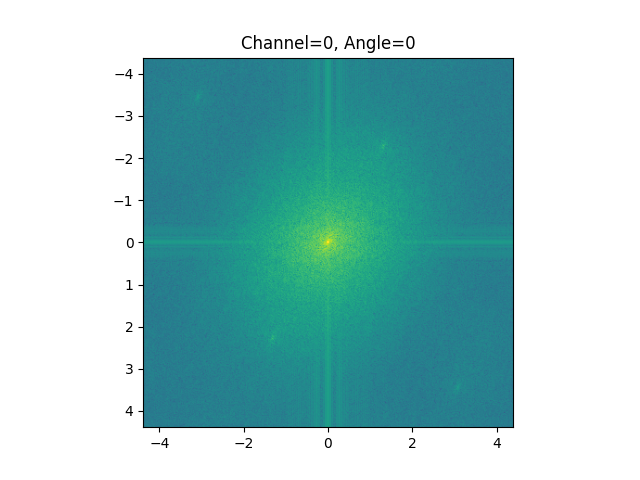

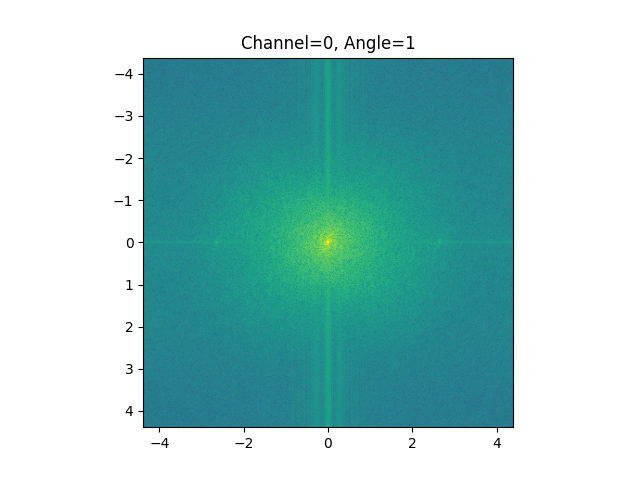

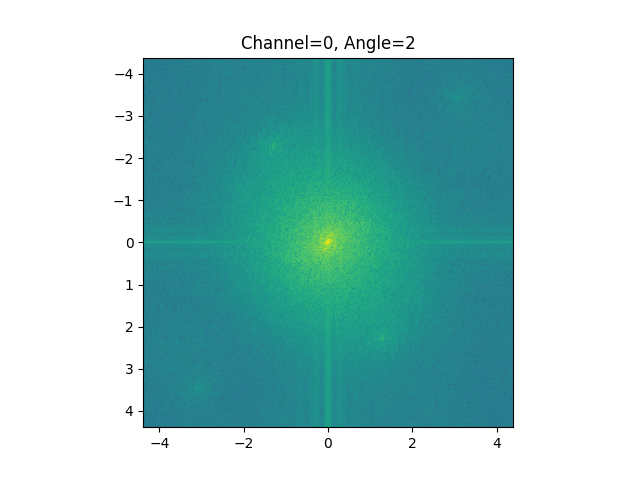

In [115]:
%matplotlib widget

# set "test" slice as determined from data
# chose a z slice with lots of data so that the SIM peaks are visible
z_test_idx=20

for ch_idx in range(n_colors):

    # extract iamges
    image_set = opsim_images_to_process[ch_idx,:,:,z_test_idx,:,:]

    # calculate FFTs on grid with correct spatial dimensions
    dx = np.round(coverslip_dx,3)
    dy = np.round(coverslip_dy,3)
    nx = nx_cropped
    ny = ny_cropped
    fxs = analysis_tools.get_fft_frqs(nx, dx)
    df = fxs[1] - fxs[0]
    fys = analysis_tools.get_fft_frqs(ny, dy)
    ff = np.sqrt(np.expand_dims(fxs, axis=0)**2 + np.expand_dims(fys, axis=1)**2)
    for ii in range(image_set.shape[0]):
        ft = fft.fftshift(fft.fft2(fft.ifftshift(np.squeeze(image_set[ii, 0, :]))))

        figh = plt.figure()
        plt.title('Channel='+str(ch_idx)+", Angle="+str(ii))
        plt.imshow(np.abs(ft), norm=PowerNorm(gamma=0.1,vmin=65,vmax=1.5e7),
                    extent=[fxs[0] - 0.5 * df, fxs[-1] + 0.5 * df, fys[-1] + 0.5 * df, fys[0] - 0.5 * df])
        plt.show()

### Setup 2D-SIM processing

In [119]:
# frequency guess from above. in k_x, k_y order
# getting these as close as possible is critical to reconstruction quality!
frq_guess = [[-1.3,2.28], [-2.6,0.005], [-1.27,-2.25]]

# phase guesses from prior knowledge
phase_guess = [[0, -4*np.pi/3,-2*np.pi/3], [0, -4*np.pi/3,-2*np.pi/3], [0, -4*np.pi/3,-2*np.pi/3]]

# algorithm parameters
# These need to be tuned for each OPSIM dataset
wiener_parameter = 0.25
band0_exclusion_fraction = 0.5

### Load point spread function and calculate optical transfer function for each angle

2D PSF extracted from OPSIM data of beads by Reto Fiolka and Peter Brown using [qi2lab localize-psf package](https://www.github.com/qi2lab/localize-psf).  

In [120]:
# load PSF from disk and tranpose to match metadata from raw data
psf2d = np.transpose(tifffile.imread(psf_file_path))
ny_psf, nx_psf = psf2d.shape

# create one PSF for each angle
psfs = np.asarray([rotate(psf2d, rotation[0], center=None, resize=False, mode='constant', cval=0, preserve_range=True),
                   psf2d,
                   rotate(psf2d, rotation[2], center=None, resize=False, mode='constant', cval=0, preserve_range=True)])

# pad to get size of image
if np.mod(ny_psf + ny_cropped, 2) != 0 or np.mod(nx_psf + nx_cropped, 2) != 0:
    raise ValueError()

# pad each PSF
ny_pad = int((ny_cropped - ny_psf) / 2)
nx_pad = int((nx_cropped - nx_psf) / 2)
psfs_padded = []
for p in psfs:
    psfs_padded.append(np.pad(p, ((ny_pad, ny_pad), (nx_pad, nx_pad)), mode="constant"))
psfs_padded = np.asarray(psfs_padded)

# get spatial frequencies on correct grid
fxs = fft.fftshift(fft.fftfreq(nx_cropped, coverslip_dx))
df = fxs[1] - fxs[0]
fys = fft.fftshift(fft.fftfreq(ny_cropped, coverslip_dy))
ff = np.sqrt(np.expand_dims(fxs, axis=0)**2 + np.expand_dims(fys, axis=1)**2)

# create OTF for each angle
fmax = 1 / (0.5 * emission_wavelengths / na)
otfs = []
for p in psfs_padded:
    otf = fft.fftshift(fft.fft2(fft.ifftshift(p)))
    otf = otf / np.max(np.abs(otf))
    otf[np.abs(otf) < 0.005] = 0
    otf[ff > fmax] = 0
    otf = np.abs(otf)

    otfs.append(otf)
otfs = np.asarray(otfs)

### Run 2D-SIM processing for z slice used to calculate frequencies above and extract reconstruction parameters
  
Modifications to [qi2lab mcSIM package](https://www.github.com/qi2lab/mcSIM) to handle OPSIM data by Peter Brown.

In [121]:
# define save path
save_path = Path("data", "example_005", "reconstruction", "test_z_plane")

# create SIM reconstruction object for z_center_idx 
imgset_test = sim.SimImageSet({'pixel_size': coverslip_dx, 'na': na, 'wavelength': emission_wavelengths},
                               opsim_images_to_process[0, :, :, z_test_idx, :],
                               frq_guess=frq_guess,
                               phases_guess=phase_guess,
                               wiener_parameter=wiener_parameter,
                               phase_estimation_mode="wicker-iterative",
                               max_phase_err=40 * np.pi / 180,
                               combine_bands_mode="fairSIM", 
                               otf=otfs,
                               fmax_exclude_band0=band0_exclusion_fraction,
                               min_p2nr=0.9,
                               gain=1, 
                               background=100,
                               save_dir=save_path,
                               save_suffix='_z'+str(z_test_idx).zfill(3)+'_ch'+str(0).zfill(3),
                               interactive_plotting=False)

# perform reconstruction, plot figures, save
imgset_test.reconstruct()
imgset_test.plot_figs()
imgset_test.save_imgs()
imgset_test.save_result()

# save reconstruction parameter for use on full stack
frqs = np.array(imgset_test.frqs, copy=True)
phases = np.array(imgset_test.phases, copy=True)
mod_depths = np.array(imgset_test.mod_depths, copy=True)

wf_image_test = imgset_test.widefield
SR_image_test = imgset_test.sim_sr

# clean up variables
del imgset_test
gc.collect()

####################################################################################
2022/28/05 11:03:33
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.04s
Computing widefield image took 0.02s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished


estimating 3 frequencies using mode band-correlation took 4.34s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


estimated 9 phases using mode wicker-iterative in 0.66
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.36s
shifted otfs in 0.08s
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.25
################ Angle 0 ################
relative intensity to max angle = 0.907
phase relative intensities = 0.893, 0.957, 1.000, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 87.463, 93.640, 94.077
modulation depth = 0.548
Frequency guess= (-1.30000, +2.28000), period=381.014nm, angle=119.691deg
Freque

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.56s
saving tiff files took 0.02s
saving results took 0.00s


330761

### Visualize test slice reconstruction

In [125]:
# define colormaps
colormaps = ['bop blue', 'bop orange']

# add images to napari viewer with scale information, colormaps, and additive blending
viewer = napari.view_image(wf_image_test,name='Widefield test',scale=(coverslip_dy,coverslip_dx),colormap = colormaps[0],blending='additive',contrast_limits=[0,np.percentile(wf_image_test, 99.9)])
viewer.add_image(SR_image_test,name='SIM test',scale=(coverslip_dy/2,coverslip_dx/2),colormap = colormaps[1],blending='additive',contrast_limits=[0,np.percentile(SR_image_test,99.9)])

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

### Reconstruct full z stack using parameters from selected z plane

In [123]:
# define save path
save_path = Path("data", "example_005", "reconstruction", "full_z_stack")

# loop over channels and z slices, perform 2D at each slice using parameters from above reconstruction
for ch_idx in range(n_colors):
    for z_idx in range(nz_cropped):
        imgs_recon = opsim_images_to_process[ch_idx, :, :, z_idx,:,:]

        imgset = sim.SimImageSet({'pixel_size': coverslip_dx, 'na': na, 'wavelength': emission_wavelengths}, 
                                imgs_recon,
                                frq_guess=frqs,
                                frq_estimation_mode="fixed",
                                phases_guess=phases,
                                phase_estimation_mode="fixed",
                                max_phase_err=40 * np.pi / 180,
                                mod_depths_guess=mod_depths,
                                use_fixed_mod_depths=True,
                                wiener_parameter=wiener_parameter,
                                combine_bands_mode="fairSIM",
                                fmax_exclude_band0=band0_exclusion_fraction,
                                otf=otfs,
                                gain=1, 
                                background=100,
                                save_dir=save_path, 
                                save_suffix='_z'+str(z_idx).zfill(3)+'_ch'+str(0).zfill(3),
                                interactive_plotting=False)
        imgset.reconstruct()
        imgset.save_result()
        imgset.save_imgs()
        imgset.plot_figs()

        # create variables to hold widefield and SIM SR images
        if ch_idx == 0 and z_idx == 0:
            wf_images = np.zeros((n_colors,nz_cropped,imgset.widefield.shape[0],imgset.widefield.shape[1]),dtype=np.float32)
            SR_images = np.zeros((n_colors,nz_cropped,imgset.sim_sr.shape[0],imgset.sim_sr.shape[1]),dtype=np.float32)

        # store widefield and SIM SR images for display
        wf_images[ch_idx,z_idx,:]=imgset.widefield
        SR_images[ch_idx,z_idx,:]=imgset.sim_sr

        # clean up variables
        del imgs_recon, imgset
        gc.collect()

####################################################################################
2022/28/05 11:09:41
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.36s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimation mode
'fixed' phase estima

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 11.16s
####################################################################################
2022/28/05 11:09:54
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.19s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.98s
####################################################################################
2022/28/05 11:10:08
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.36s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.19s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.92s
####################################################################################
2022/28/05 11:10:21
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
Angle 1, minimum SIM peak-to-noise ratio = 0.46 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.19s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.91s
####################################################################################
2022/28/05 11:10:34
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
Angle 1, minimum SIM peak-to-noise ratio = 0.89 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.20s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.87s
####################################################################################
2022/28/05 11:10:47
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.48 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 1, minimum SIM peak-to-noise ratio = 0.48 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.80s
####################################################################################
2022/28/05 11:10:59
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
Angle 1, minimum SIM peak-to-noise ratio = 0.90 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.78s
####################################################################################
2022/28/05 11:11:12
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.03s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.74s
####################################################################################
2022/28/05 11:11:25
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.69s
####################################################################################
2022/28/05 11:11:38
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.68s
####################################################################################
2022/28/05 11:11:51
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.62s
####################################################################################
2022/28/05 11:12:03
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.64s
####################################################################################
2022/28/05 11:12:16
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.36s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.62s
####################################################################################
2022/28/05 11:12:29
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.61s
####################################################################################
2022/28/05 11:12:42
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.19s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.58s
####################################################################################
2022/28/05 11:12:54
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.36s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.60s
####################################################################################
2022/28/05 11:13:07
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.55s
####################################################################################
2022/28/05 11:13:20
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.20s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.55s
####################################################################################
2022/28/05 11:13:32
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.50s
####################################################################################
2022/28/05 11:13:45
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.49s
####################################################################################
2022/28/05 11:13:57
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.19s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.49s
####################################################################################
2022/28/05 11:14:10
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.48s
####################################################################################
2022/28/05 11:14:23
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.19s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.48s
####################################################################################
2022/28/05 11:14:35
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.36s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.46s
####################################################################################
2022/28/05 11:14:48
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.47s
####################################################################################
2022/28/05 11:15:00
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.03s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.44s
####################################################################################
2022/28/05 11:15:13
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.43s
####################################################################################
2022/28/05 11:15:25
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.45s
####################################################################################
2022/28/05 11:15:38
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.42s
####################################################################################
2022/28/05 11:15:50
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.19s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.39s
####################################################################################
2022/28/05 11:16:03
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.40s
####################################################################################
2022/28/05 11:16:15
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.38s
####################################################################################
2022/28/05 11:16:28
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.37s
####################################################################################
2022/28/05 11:16:40
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.44s
####################################################################################
2022/28/05 11:16:53
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.39s
####################################################################################
2022/28/05 11:17:05
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.42s
####################################################################################
2022/28/05 11:17:18
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.37s
####################################################################################
2022/28/05 11:17:30
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.37s
####################################################################################
2022/28/05 11:17:43
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.35s
####################################################################################
2022/28/05 11:17:55
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.39s
####################################################################################
2022/28/05 11:18:08
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.37s
####################################################################################
2022/28/05 11:18:20
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.32s
####################################################################################
2022/28/05 11:18:33
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.20s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.36s
####################################################################################
2022/28/05 11:18:45
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.38s
####################################################################################
2022/28/05 11:18:57
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.19s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.37s
####################################################################################
2022/28/05 11:19:10
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.38s
####################################################################################
2022/28/05 11:19:22
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.37s
####################################################################################
2022/28/05 11:19:35
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.35s
####################################################################################
2022/28/05 11:19:47
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.03s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.35s
####################################################################################
2022/28/05 11:20:00
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.34s
####################################################################################
2022/28/05 11:20:12
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.36s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.35s
####################################################################################
2022/28/05 11:20:25
####################################################################################
Normalizing histograms took 0.09s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.20s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.33s
####################################################################################
2022/28/05 11:20:37
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.35s
####################################################################################
2022/28/05 11:20:49
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.19s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.34s
####################################################################################
2022/28/05 11:21:02
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.10s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.33s
####################################################################################
2022/28/05 11:21:14
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.42s
####################################################################################
2022/28/05 11:21:27
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.35s
####################################################################################
2022/28/05 11:21:39
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.02s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.33s
####################################################################################
2022/28/05 11:21:52
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.34s
####################################################################################
2022/28/05 11:22:04
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.36s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.32s
####################################################################################
2022/28/05 11:22:16
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.19s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.39s
####################################################################################
2022/28/05 11:22:29
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.35s
####################################################################################
2022/28/05 11:22:41
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.39s
####################################################################################
2022/28/05 11:22:54
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.38s
####################################################################################
2022/28/05 11:23:06
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.42s
####################################################################################
2022/28/05 11:23:19
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
Angle 1, minimum SIM peak-to-noise ratio = 0.83 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.44s
####################################################################################
2022/28/05 11:23:31
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
Angle 1, minimum SIM peak-to-noise ratio = 0.90 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.48s
####################################################################################
2022/28/05 11:23:44
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.49s
####################################################################################
2022/28/05 11:23:56
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.19s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.49s
####################################################################################
2022/28/05 11:24:09
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.57s
####################################################################################
2022/28/05 11:24:22
####################################################################################
Normalizing histograms took 0.08s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.18s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.61s
####################################################################################
2022/28/05 11:24:34
####################################################################################
Normalizing histograms took 0.07s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.06s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.34s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.16s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.17s
Deconvolved widefield in 0.08s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.73s
####################################################################################
2022/28/05 11:24:47
####################################################################################
Normalizing histograms took 0.07s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
Angle 1, minimum SIM peak-to-noise ratio = 0.89 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.36s
shifted otfs in 0.08s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.74s
####################################################################################
2022/28/05 11:25:00
####################################################################################
Normalizing histograms took 0.07s
FT images took 0.04s
Computing widefield image took 0.03s
estimating 3 frequencies using mode fixed took 0.00s
Angle 0, minimum SIM peak-to-noise ratio = 0.38 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
Angle 1, minimum SIM peak-to-noise ratio = 0.24 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.07s
using fixed modulation depth
estimated global phases and mod depths in 0.08s
computed band weights in 0.17s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.76s
####################################################################################
2022/28/05 11:25:13
####################################################################################
Normalizing histograms took 0.07s
FT images took 0.04s
Computing widefield image took 0.02s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.03s
estimated modulation-contrast-to-noise ratio in 0.05s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.01s
separated bands in 0.01s
estimated noise in 0.02s
shifted bands in 0.35s
shifted otfs in 0.09s
using fixed modulation depth
estimated global phases and mod depths in 0.09s
computed band weights in 0.17s
combining bands using mode 'fairSIM' and Wiener parameter 0.250 took 0.18s
Deconvolved widefield in 0.07s
SIM reconstruction for 3 angles and 3 phases
images are size 399x399 with pixel size 0.114um
emission wavelength=580nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 10.79s


### Visualize reconstruction of full stack

In [126]:
# define colormaps
colormaps = ['bop purple', 'bop blue', 'bop orange']

# add images to napari viewer with scale information, colormaps, and additive blending
for ch_idx in range(n_colors):
    if ch_idx == 0:
        viewer = napari.view_image(wf_images[ch_idx,:],name='Widefield CH '+str(ch_idx).zfill(2),scale=(coverslip_dz,coverslip_dy,coverslip_dx),colormap = colormaps[ch_idx],blending='additive',contrast_limits=[0,np.percentile(wf_images[ch_idx,:], 99.9)])
        viewer.add_image(SR_images[ch_idx,:],name='SR CH '+str(ch_idx).zfill(2),scale=(coverslip_dz,coverslip_dy/2,coverslip_dx/2),colormap = colormaps[ch_idx],blending='additive',contrast_limits=[0,np.percentile(SR_images[ch_idx,:], 99.99)])
    else:
        viewer.add_image(wf_images[ch_idx,:],name='Widefield CH '+str(ch_idx).zfill(2),scale=(coverslip_dz,coverslip_dy,coverslip_dx),colormap = colormaps[ch_idx],blending='additive',contrast_limits=[0,np.percentile(wf_images[ch_idx,:], 99.9)])
        viewer.add_image(SR_images[ch_idx,:],name='SR CH '+str(ch_idx).zfill(2),scale=(coverslip_dz,coverslip_dy/2,coverslip_dx/2),colormap = colormaps[ch_idx],blending='additive',contrast_limits=[0,np.percentile(SR_images[ch_idx,:], 99.99)])

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

### Write widefield and OPSIM reconstructions to disk

In [127]:
# loop over all channels
for ch_idx in range(n_colors):
  # widefield
  save_path_wf = Path("data", "example_005", "reconstruction", "ch_"+str(ch_idx).zfill(3)+"_reconstruction_wf.tif")
  tifffile.imwrite(save_path_wf,
                  wf_images[ch_idx,:], 
                  imagej=True, 
                  resolution=(1./(coverslip_dx), 1./(coverslip_dy)), 
                  metadata={'spacing': coverslip_dz, 'unit': 'um', 'min': 0,'max': np.percentile(wf_images, 99.9),'axes': 'ZYX'})

  # opsim
  save_path_opsim = Path("data", "example_005", "reconstruction", "ch_"+str(ch_idx).zfill(3)+"_reconstruction_opsim.tif")
  tifffile.imwrite(save_path_opsim, 
                  SR_images[ch_idx,:], 
                  imagej=True, 
                  resolution=(1./(coverslip_dx/2), 1./(coverslip_dy/2)), 
                  metadata={'spacing': coverslip_dz, 'unit': 'um', 'min': 0,'max': np.percentile(SR_images, 99.95),'axes': 'ZYX'})